In this notebook, we look at the possibility to have the overlap between two neutron star merger. We have seen that the overlap of two black holes was a problem only when the mergers are very close to each other. Here, we look at what would happen if two neutron star signals overlap

First we look at GW170814 alone to see how it works and evolve alone. Also in order to have the amplitude and find and injection that is reasonable with respect to that

In [1]:
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
#library

from pycbc.filter import highpass, sigma
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import matched_filter
import numpy as np

In [3]:
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

In [4]:
strainL1 = strain['L1']
strainFL1 = stilde['L1']
idx = strainL1.numpy().argmax()
maxAmp = strainL1[idx]
maxAmpT = strainL1.sample_times[idx]

(1e-47, 1e-42)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


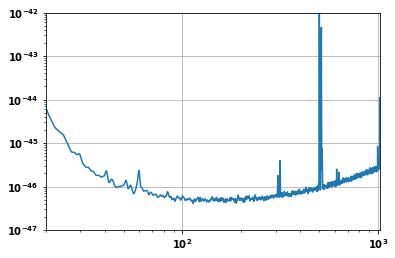

In [5]:
psd = strainL1.psd(2)
psd = interpolate(psd, strainL1.delta_f)
psd = inverse_spectrum_truncation(psd, 2*strainL1.sample_rate, 
                                 low_frequency_cutoff = 15.,
                                 trunc_method = 'hann')

plt.loglog(psd.sample_frequencies, psd)
plt.xlim(20,1024)
plt.grid()
plt.ylim(1e-47, 1e-42)

In [6]:
#test to find the signal in one detector only
mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax = None
maxsnr, m1max, m2max, tmax = 0, 0, 0, 0

snrs = [[] for i in range(len(mass1))]
max_snrs = [[] for i in range(len(mass1))]
times_max = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = strainFL1.delta_f)
        hp.resize(len(strainFL1))
        
        #do the max filtering
        snr = matched_filter(hp, strainFL1, psd = psd, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrs[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs[i].append(snrp)
        time = snr.sample_times[idx]
        times_max[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnr:
            tmax, hmax, m1max, m2max, maxsnr = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max, m2max, tmax, maxsnr))

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.9218268


In [6]:
print(maxAmp)

3.3623787798909603e-20


We need to make a neutron star model with an amplitude comparable to that of the signal.

First, we only make a neutron star merger to see if it works

In [8]:
ind = hpNS.numpy().argmax()
max_amp = hpNS[ind]

print(max_amp)

1.5124164761374562e-20


In [108]:
#we try to put the signal at 100 s to see if it works

time_shifts = np.arange(1, 200, 0.2)

modelNH = None
maxAmpNH, timeNH, time_dif = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < - 109.5) and (timeDif > -110.5) :
        print("in loop")
        modelNH = hpInjL
        maxAmpNH, timeNH, time_dif = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop
in loop
in loop
in loop


In [109]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNH)
print("The time of this maximum is: ", timeNH)
print("The time of the meger is: ", merger.time-1)
print("The time difference is: ", time_dif)

('The maximum amplitude of the injection is: ', 3.2461011542845937e-22)
('The time of this maximum is: ', 1187008772.821631)
('The time of the meger is: ', 1187008881.4)
('The time difference is: ', -109.578369140625)


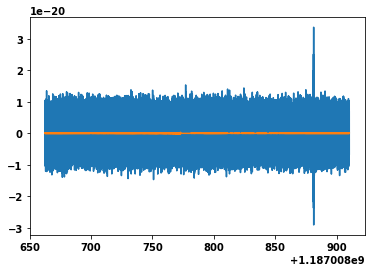

In [110]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelNH.sample_times, modelNH, label = 'injection')
#plt.axvline(maxAmpT, color = 'red', alpha = 0.5)

In [111]:
hpNS, _ = get_td_waveform(approximant = 'SEOBNRv4T', mass1 = 1.48, 
                         mass2 = 1.28, f_lower = 20, 
                          delta_t = strainL1.delta_t)

hpNS.resize(len(strainL1))
hpNS.start_time = strainL1.start_time

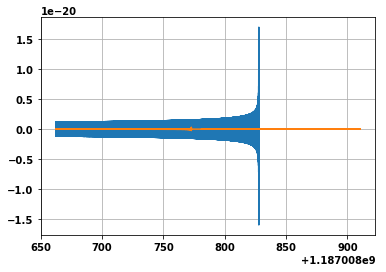

In [112]:
plt.plot(hpNS.sample_times, hpNS, label = 'GW170817')
plt.plot(modelNH.sample_times, modelNH, label = 'injection')
plt.grid()

In [113]:
ind = modelNH.numpy().argmax()
maxAmpT = modelNH.sample_times[ind]
modelZ = modelNH


for i in range(ind + 4096, len(modelZ), 1):
    modelZ[i] = 0

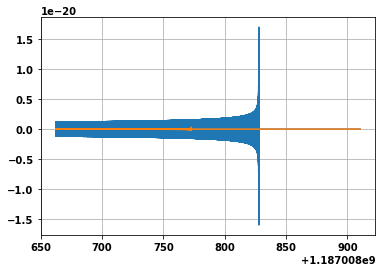

In [114]:
plt.plot(hpNS.sample_times, hpNS, label = 'GW170817')
plt.plot(modelZ.sample_times, modelZ, label = 'injection')
plt.grid()

In order to avoid the artifacts that are due to the signal that is present, we will put it at zero after the ring donw (max + 2sec). This will enable to see the influence on the principal merger that is present

In [115]:
signal = strainL1 + modelZ
signalF = signal.to_frequencyseries()

(1e-47, 1e-42)

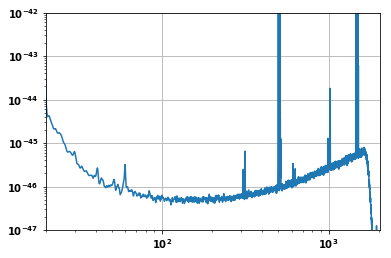

In [116]:
#psd of the subtracted signal

p = signal.psd(2)
p = interpolate(p, signal.delta_f)
psd = inverse_spectrum_truncation(p, 2*signal.sample_rate, 
                                 low_frequency_cutoff = 20.)


plt.loglog(psd.sample_frequencies, psd)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

Text(0,0.5,'Normalized amplitude')

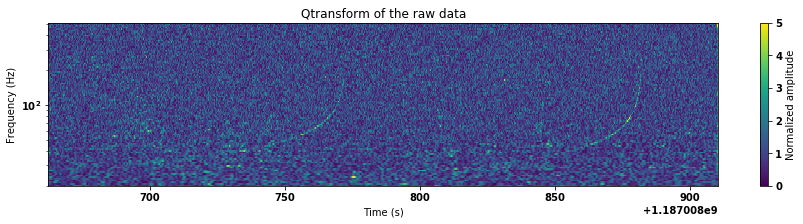

In [117]:
#qtransform of the data

white_sig = (signalF/psd**0.5).to_timeseries()
t, f, p = white_sig.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")


In [118]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax = None
maxsnr, m1max, m2max, tmax = 0, 0, 0, 0

snrs = [[] for i in range(len(mass1))]
max_snrs = [[] for i in range(len(mass1))]
times_max = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = signalF.delta_f)
        hp.resize(len(signalF))
        
        #do the max filtering
        snr = matched_filter(hp, signalF, psd = psd, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrs[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs[i].append(snrp)
        time = snr.sample_times[idx]
        times_max[i].append(time)
        
        if snrp > maxsnr:
            tmax, hmax, m1max, m2max, maxsnr = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print()
 
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max, m2max, tmax, maxsnr))
print(merger.time)
print(maxAmpT)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
()
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.8598764
1187008882.4
1187008772.821631


In [119]:
#trial to look at the toehr event
mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB = None
maxsnrB, m1maxB, m2max, tmaxB = 0, 0, 0, 0

snrsB = [[] for i in range(len(mass1))]
max_snrsB = [[] for i in range(len(mass1))]
times_maxB = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = signalF.delta_f)
        hp.resize(len(signalF))
        
        #do the max filtering
        snr = matched_filter(hp, signalF, psd = psd, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsB[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsB[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxB[i].append(time)
        
        if snrp > maxsnrB:
            tmaxB, hmaxB, m1maxB, m2maxB, maxsnrB = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print()
 
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB, m2maxB, tmaxB, maxsnrB))
print(merger.time)
print(maxAmpT)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
()
We found the best masses m1 = 1.090 and m2 = 1.110 at the time 1187008772.8240724 with a SNR of 35.2294011
1187008882.4
1187008772.821631


We see that the two events can be found in this case

## For 50 s

In [3]:
#download data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()
    

strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [4]:
#make the injection
time_shifts = np.arange(1, 200, 0.2)

modelNS50 = None
maxAmpNS50, timeNS50, time_dif50 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < - 49.8) and (timeDif > -50.3) :
        print("in loop")
        modelNS50 = hpInjL
        maxAmpNS50, timeNS50, time_dif50 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [6]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS50)
print("The time of this maximum is: ", timeNS50)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif50)


('The maximum amplitude of the injection is: ', 3.1134576960524294e-22)
('The time of this maximum is: ', 1187008832.422217)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -49.977783203125)


In [9]:
#puting to zero all that is after the ring down
ind = modelNS50.numpy().argmax()
maxAmpT = modelNS50.sample_times[ind]
modelZ = modelNS50


for i in range(ind + 4096, len(modelZ), 1):
    modelZ[i] = 0


sig50 = strainL1 + modelZ
sigF50 = sig50.to_frequencyseries()

In [10]:
#psd of the added signal

p50 = sig50.psd(2)
p50 = interpolate(p50, sig50.delta_f)
psd50 = inverse_spectrum_truncation(p50, 2*sig50.sample_rate, 
                                 low_frequency_cutoff = 20.)

(1187008802.4, 1187008887.4)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


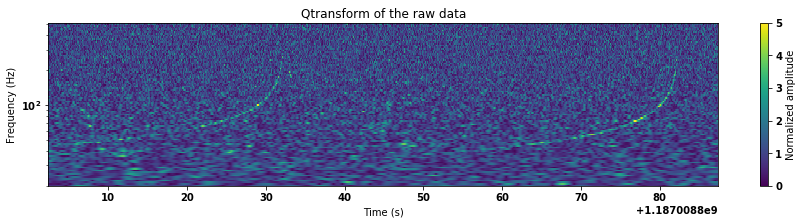

In [11]:
#qtransform of the data

white_sig50 = (sigF50/psd50**0.5).to_timeseries()
zoom = white_sig50.time_slice(merger.time - 85, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 80, merger.time + 5)


In [12]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax50 = None
maxsnr50, m1max50, m2max50, tmax50 = 0, 0, 0, 0

snrs50 = [[] for i in range(len(mass1))]
max_snrs50 = [[] for i in range(len(mass1))]
times_max50 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF50.delta_f)
        hp.resize(len(sigF50))
        
        #do the max filtering
        snr = matched_filter(hp, sigF50, psd = psd50, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrs50[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs50[i].append(snrp)
        time = snr.sample_times[idx]
        times_max50[i].append(time)
        
        if snrp > maxsnr50:
            tmax50, hmax50, m1max50, m2max50, maxsnr50 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max50, m2max50, tmax50, maxsnr50))
print(merger.time)
print(maxAmpT)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.8698110
1187008882.4
1187008832.422217


In [13]:
#trial to look at the other event
mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB50 = None
maxsnrB50, m1maxB50, m2maxB50, tmaxB50 = 0, 0, 0, 0

snrsB50 = [[] for i in range(len(mass1))]
max_snrsB50 = [[] for i in range(len(mass1))]
times_maxB50 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF50.delta_f)
        hp.resize(len(sigF50))
        
        #do the max filtering
        snr = matched_filter(hp, sigF50, psd = psd50, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsB50[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsB50[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxB50[i].append(time)
        
        if snrp > maxsnrB50:
            tmaxB50, hmaxB50, m1maxB50, m2maxB50, maxsnrB50 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB50, m2maxB50, tmaxB50, maxsnrB50))
print(merger.time)
print(maxAmpT)


Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008832.4229493 with a SNR of 31.2778294
1187008882.4
1187008832.422217


## For 25s

In [3]:
#download data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()
    

strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [4]:
#make the injection
time_shifts = np.arange(200, 300, 0.2)

modelNS25 = None
maxAmpNS25, timeNS25, time_dif25 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < - 24.7) and (timeDif > -25.3) :
        print("in loop")
        modelNS25 = hpInjL
        maxAmpNS25, timeNS25, time_dif25 = max_amp, time_inj, timeDif



Waveform obtained
in loop
in loop
in loop


In [5]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS25)
print("The time of this maximum is: ", timeNS25)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif25)

('The maximum amplitude of the injection is: ', 3.1377684336213185e-22)
('The time of this maximum is: ', 1187008857.6216798)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -24.7783203125)


In [6]:
#puting to zero all that is after the ring down
ind = modelNS25.numpy().argmax()
maxAmpT = modelNS25.sample_times[ind]
modelZ = modelNS25.copy()


for i in range(ind + 4096, len(modelZ), 1):
    modelZ[i] = 0


sig25 = strainL1 + modelZ
sigF25 = sig25.to_frequencyseries()

(1e-47, 1e-42)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


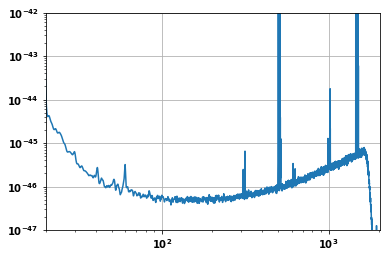

In [7]:
#psd of the added signal

p25 = sig25.psd(2)
p25 = interpolate(p25, sig25.delta_f)
psd25 = inverse_spectrum_truncation(p25, 2*sig25.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psd25.sample_frequencies, psd25)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

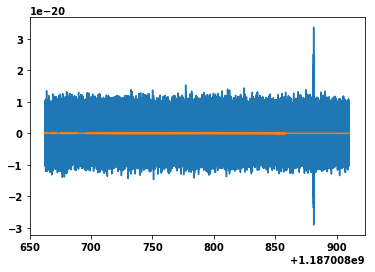

In [8]:
plt.plot(sig25.sample_times, sig25, label = 'sig')
plt.plot(modelZ.sample_times, modelZ, label = 'model')

(1187008802.4, 1187008892.4)

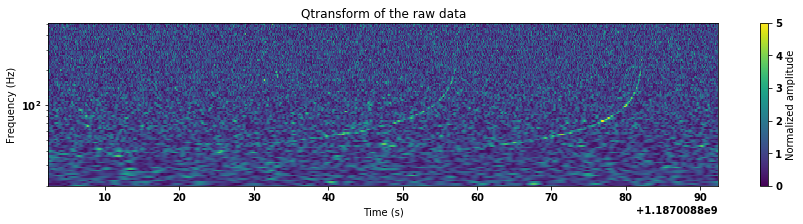

In [9]:
#qtransform of the data

white_sig25 = (sigF25/psd25**0.5).to_timeseries()
zoom = white_sig25.time_slice(merger.time - 85, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 80, merger.time + 10)

In [10]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax25 = None
maxsnr25, m1max25, m2max25, tmax25 = 0, 0, 0, 0

snrs25 = [[] for i in range(len(mass1))]
max_snrs25 = [[] for i in range(len(mass1))]
times_max25 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF25.delta_f)
        hp.resize(len(sigF25))
        
        #do the max filtering
        snr = matched_filter(hp, sigF25, psd = psd25, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrs25[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs25[i].append(snrp)
        time = snr.sample_times[idx]
        times_max25[i].append(time)
        
        if snrp > maxsnr25:
            tmax25, hmax25, m1max25, m2max25, maxsnr25 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max25, m2max25, tmax25, maxsnr25))
print(merger.time)
print(maxAmpT)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.8405380
1187008882.4
1187008857.6216798


In [12]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB25 = None
maxsnrB25, m1maxB25, m2maxB25, tmaxB25 = 0, 0, 0, 0

snrsB25 = [[] for i in range(len(mass1))]
max_snrsB25 = [[] for i in range(len(mass1))]
times_maxB25 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF25.delta_f)
        hp.resize(len(sigF25))
        
        #do the max filtering
        snr = matched_filter(hp, sigF25, psd = psd25, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsB25[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsB25[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxB25[i].append(time)
        
        if snrp > maxsnrB25:
            tmaxB25, hmaxB25, m1maxB25, m2maxB25, maxsnrB25 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB25, m2maxB25, tmaxB25, maxsnrB25))
print(merger.time)
print(maxAmpT)


Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.090 and m2 = 1.110 at the time 1187008857.6246095 with a SNR of 32.0295561
1187008882.4
1187008857.6216798


The two events are still well found here

## For 10 s

In [3]:
#download data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()
    

strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [4]:
#make the injection
time_shifts = np.arange(200, 300, 0.2)

modelNS10 = None
maxAmpNS10, timeNS10, time_dif10 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < - 9.8) and (timeDif > -10.3) :
        print("in loop")
        modelNS10 = hpInjL
        maxAmpNS10, timeNS10, time_dif10 = max_amp, time_inj, timeDif


Waveform obtained
in loop
in loop


In [5]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS10)
print("The time of this maximum is: ", timeNS10)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif10)

('The maximum amplitude of the injection is: ', 3.1134577036374144e-22)
('The time of this maximum is: ', 1187008872.422217)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -9.977783203125)


In [6]:
#puting to zero all that is after the ring down
ind = modelNS10.numpy().argmax()
maxAmpT = modelNS10.sample_times[ind]
modelZ10 = modelNS10


for i in range(ind + 4096, len(modelZ10), 1):
    modelZ10[i] = 0


sig10 = strainL1 + modelZ10
sigF10 = sig10.to_frequencyseries()

(1e-47, 1e-42)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


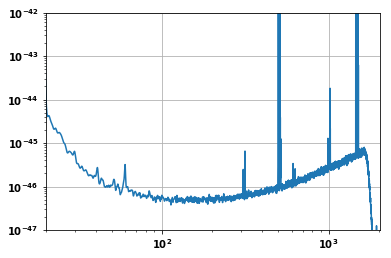

In [7]:
#psd of the added signal

p10 = sig10.psd(2)
p10 = interpolate(p10, sig10.delta_f)
psd10 = inverse_spectrum_truncation(p10, 2*sig10.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psd10.sample_frequencies, psd10)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008842.4, 1187008887.4)

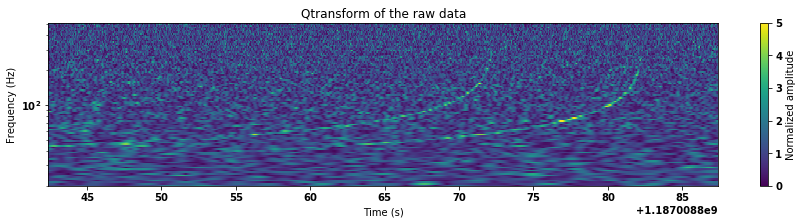

In [8]:
#qtransform of the data

white_sig10 = (sigF10/psd10**0.5).to_timeseries()
zoom = white_sig10.time_slice(merger.time - 45, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 40, merger.time + 5)

In [21]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax10 = None
maxsnr10, m1max10, m2max10, tmax10 = 0, 0, 0, 0

snrs10 = [[] for i in range(len(mass1))]
max_snrs10 = [[] for i in range(len(mass1))]
times_max10 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF10.delta_f)
        hp.resize(len(sigF10))
        
        #do the max filtering
        snr = matched_filter(hp, sigF10, psd = psd10, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrs10[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs10[i].append(snrp)
        time = snr.sample_times[idx]
        times_max10[i].append(time)
        
        if snrp > maxsnr10:
            tmax10, hmax10, m1max10, m2max10, maxsnr10 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max10, m2max10, tmax10, maxsnr10))
print(merger.time)
print(maxAmpT)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.8387562
1187008882.4
1187008872.422217


In [9]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB10 = None
maxsnrB10, m1maxB10, m2maxB10, tmaxB10 = 0, 0, 0, 0

snrsB10 = [[] for i in range(len(mass1))]
max_snrsB10 = [[] for i in range(len(mass1))]
times_maxB10 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF10.delta_f)
        hp.resize(len(sigF10))
        
        #do the max filtering
        snr = matched_filter(hp, sigF10, psd = psd10, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsB10[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsB10[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxB10[i].append(time)
        
        if snrp > maxsnrB10:
            tmaxB10, hmaxB10, m1maxB10, m2maxB10, maxsnrB10 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB10, m2maxB10, tmaxB10, maxsnrB10))
print(merger.time)
print(maxAmpT)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008872.4229493 with a SNR of 32.1616423
1187008882.4
1187008872.422217


OK

## For 5 s

In [5]:
#make the injection
time_shifts = np.arange(200, 300, 0.2)

modelNS5 = None
maxAmpNS5, timeNS5, time_dif5 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < - 4.8) and (timeDif > -5.3) :
        print("in loop")
        modelNS5 = hpInjL
        maxAmpNS5, timeNS5, time_dif5 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [6]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS5)
print("The time of this maximum is: ", timeNS5)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif5)

('The maximum amplitude of the injection is: ', 3.113457705685868e-22)
('The time of this maximum is: ', 1187008877.422217)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -4.977783203125)


In [7]:
#puting to zero all that is after the ring down
ind = modelNS5.numpy().argmax()
maxAmpT5 = modelNS5.sample_times[ind]
modelZ5 = modelNS5


for i in range(ind + 4096, len(modelZ5), 1):
    modelZ5[i] = 0


sig5 = strainL1 + modelZ5
sigF5 = sig5.to_frequencyseries()

(1e-47, 1e-42)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


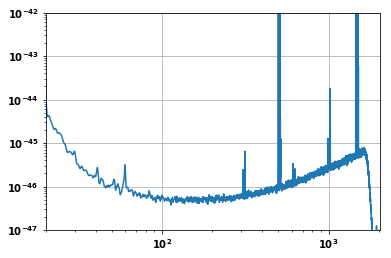

In [8]:
#psd of the added signal

p5 = sig5.psd(2)
p5 = interpolate(p5, sig5.delta_f)
psd5 = inverse_spectrum_truncation(p5, 2*sig5.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psd5.sample_frequencies, psd5)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008842.4, 1187008887.4)

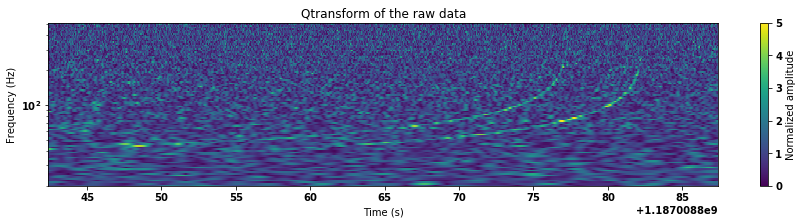

In [9]:
#qtransform of the data

white_sig5 = (sigF5/psd5**0.5).to_timeseries()
zoom = white_sig5.time_slice(merger.time - 45, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 40, merger.time + 5)

In [16]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax5 = None
maxsnr5, m1max5, m2max5, tmax5 = 0, 0, 0, 0

snrs5 = [[] for i in range(len(mass1))]
max_snrs5 = [[] for i in range(len(mass1))]
times_max5 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF5.delta_f)
        hp.resize(len(sigF5))
        
        #do the max filtering
        snr = matched_filter(hp, sigF5, psd = psd5, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrs5[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs5[i].append(snrp)
        time = snr.sample_times[idx]
        times_max5[i].append(time)
        
        if snrp > maxsnr5:
            tmax5, hmax5, m1max5, m2max5, maxsnr5 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max5, m2max5, tmax5, maxsnr5))
print(merger.time)
print(maxAmpT5)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.8130331
1187008882.4
1187008877.422217


In [10]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB5 = None
maxsnrB5, m1maxB5, m2maxB5, tmaxB5 = 0, 0, 0, 0

snrsB5 = [[] for i in range(len(mass1))]
max_snrsB5 = [[] for i in range(len(mass1))]
times_maxB5 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF5.delta_f)
        hp.resize(len(sigF5))
        
        #do the max filtering
        snr = matched_filter(hp, sigF5, psd = psd5, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsB5[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsB5[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxB5[i].append(time)
        
        if snrp > maxsnrB5:
            tmaxB5, hmaxB5, m1maxB5, m2maxB5, maxsnrB5 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB5, m2maxB5, tmaxB5, maxsnrB5))
print(merger.time)
print(maxAmpT5)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008877.4229493 with a SNR of 31.9939049
1187008882.4
1187008877.422217


OK

## For 1 s difference 

In [9]:
#make the injection
time_shifts = np.arange(200, 300, 0.2)

modelNS1 = None
maxAmpNS1, timeNS1, time_dif1 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < - 0.8) and (timeDif > -1.3) :
        print("in loop")
        modelNS1 = hpInjL
        maxAmpNS1, timeNS1, time_dif1 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [10]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS1)
print("The time of this maximum is: ", timeNS1)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif1)


('The maximum amplitude of the injection is: ', 3.1134577077013537e-22)
('The time of this maximum is: ', 1187008881.422217)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.977783203125)


In [11]:
#puting to zero all that is after the ring down
ind = modelNS1.numpy().argmax()
maxAmpT1 = modelNS1.sample_times[ind]
modelZ1 = modelNS1


for i in range(ind + 4096, len(modelZ1), 1):
    modelZ1[i] = 0


sig1 = strainL1 + modelZ1
sigF1 = sig1.to_frequencyseries()

(1e-47, 1e-42)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


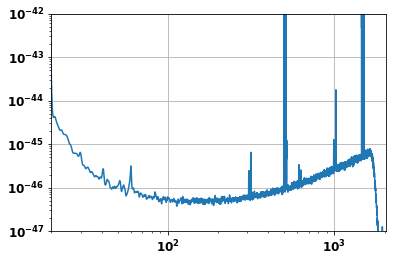

In [12]:
#psd of the added signal

p1 = sig1.psd(2)
p1 = interpolate(p1, sig1.delta_f)
psd1 = inverse_spectrum_truncation(p1, 2*sig1.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psd1.sample_frequencies, psd1)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008887.4)

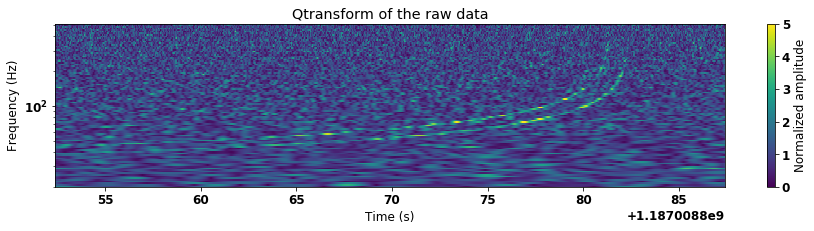

In [14]:
#qtransform of the data

white_sig1 = (sigF1/psd1**0.5).to_timeseries()
zoom = white_sig1.time_slice(merger.time - 35, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [15]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax1 = None
maxsnr1, m1max1, m2max1, tmax1 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF1.delta_f)
        hp.resize(len(sigF1))
        
        #do the max filtering
        snr = matched_filter(hp, sigF1, psd = psd1, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnr1:
            tmax1, hmax1, m1max1, m2max1, maxsnr1 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max1, m2max1, tmax1, maxsnr1))
print(merger.time)
print(maxAmpT1)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.8352255
1187008882.4
1187008881.422217


In [18]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB1 = None
maxsnrB1, m1maxB1, m2maxB1, tmaxB1 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF1.delta_f)
        hp.resize(len(sigF1))
        
        #do the max filtering
        snr = matched_filter(hp, sigF1, psd = psd1, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrB1:
            tmaxB1, hmaxB1, m1maxB1, m2maxB1, maxsnrB1 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB1, m2maxB1, tmaxB1, maxsnrB1))
print(merger.time)
print(maxAmpT1)


Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008881.4229493 with a SNR of 32.6960367
1187008882.4
1187008881.422217


It works

## For 0.5s

In [19]:
#make the injection
time_shifts = np.arange(210, 290, 0.1)

modelNS05 = None
maxAmpNS05, timeNS05, time_dif05 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < - .3) and (timeDif > -0.7) :
        print("in loop")
        modelNS05 = hpInjL
        maxAmpNS05, timeNS05, time_dif05 = max_amp, time_inj, timeDif


Waveform obtained
in loop
in loop
in loop
in loop


In [20]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS05)
print("The time of this maximum is: ", timeNS05)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif05)


('The maximum amplitude of the injection is: ', 2.8036739295264842e-22)
('The time of this maximum is: ', 1187008882.0228028)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.377197265625)


In [21]:
#puting to zero all that is after the ring down
ind = modelNS05.numpy().argmax()
maxAmpT05 = modelNS05.sample_times[ind]
modelZ05 = modelNS05


for i in range(ind + 4096, len(modelZ05), 1):
    modelZ05[i] = 0


sig05 = strainL1 + modelZ05
sigF05 = sig05.to_frequencyseries()


(1e-47, 1e-42)

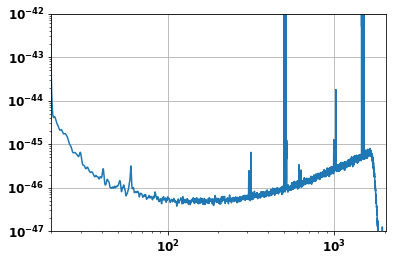

In [23]:
#psd of the added signal

p05 = sig05.psd(2)
p05 = interpolate(p05, sig05.delta_f)
psd05 = inverse_spectrum_truncation(p05, 2*sig05.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psd05.sample_frequencies, psd05)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008887.4)

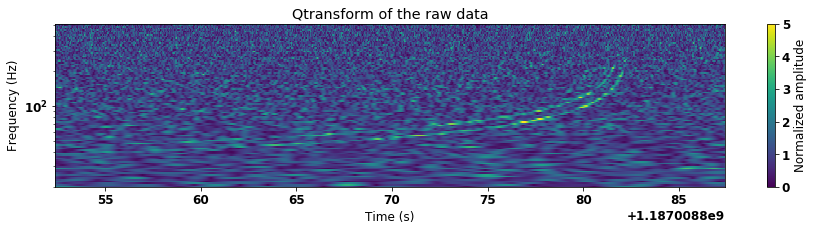

In [24]:
#qtransform of the data

white_sig05 = (sigF05/psd05**0.5).to_timeseries()
zoom = white_sig05.time_slice(merger.time - 35, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [25]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax05 = None
maxsnr05, m1max05, m2max05, tmax05 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF05.delta_f)
        hp.resize(len(sigF05))
        
        #do the max filtering
        snr = matched_filter(hp, sigF05, psd = psd05, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnr05:
            tmax05, hmax05, m1max05, m2max05, maxsnr05 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max05, m2max05, tmax05, maxsnr05))
print(merger.time)
print(maxAmpT05)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.7928870
1187008882.4
1187008882.0228028


In [26]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB05 = None
maxsnrB05, m1maxB05, m2maxB05, tmaxB05 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF05.delta_f)
        hp.resize(len(sigF05))
        
        #do the max filtering
        snr = matched_filter(hp, sigF05, psd = psd05, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrB05:
            tmaxB05, hmaxB05, m1maxB05, m2maxB05, maxsnrB05 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB05, m2maxB05, tmaxB05, maxsnrB05))
print(merger.time)
print(maxAmpT05)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008882.0235353 with a SNR of 35.1681062
1187008882.4
1187008882.0228028


The subtraction still works

## For 0.1 s

In [38]:
#make the injection
time_shifts = np.arange(227, 233, 0.01)

modelNS01 = None
maxAmpNS01, timeNS01, time_dif01 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < - 0.08) and (timeDif > -0.15) :
        print("in loop")
        modelNS01 = hpInjL
        maxAmpNS01, timeNS01, time_dif01 = max_amp, time_inj, timeDif


Waveform obtained
in loop
in loop
in loop
in loop
in loop
in loop
in loop


In [39]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS01)
print("The time of this maximum is: ", timeNS01)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif01)

('The maximum amplitude of the injection is: ', 3.1725128612732704e-22)
('The time of this maximum is: ', 1187008882.3116212)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.08837890625)


In [40]:
#puting to zero all that is after the ring down
ind = modelNS01.numpy().argmax()
maxAmpT01 = modelNS01.sample_times[ind]
modelZ01 = modelNS01


for i in range(ind + 4096, len(modelZ01), 1):
    modelZ01[i] = 0


sig01 = strainL1 + modelZ01
sigF01 = sig01.to_frequencyseries()


(1e-47, 1e-42)

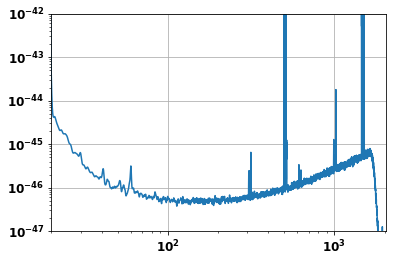

In [41]:
#psd of the added signal

p01 = sig01.psd(2)
p01 = interpolate(p01, sig01.delta_f)
psd01 = inverse_spectrum_truncation(p01, 2*sig01.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psd01.sample_frequencies, psd01)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008887.4)

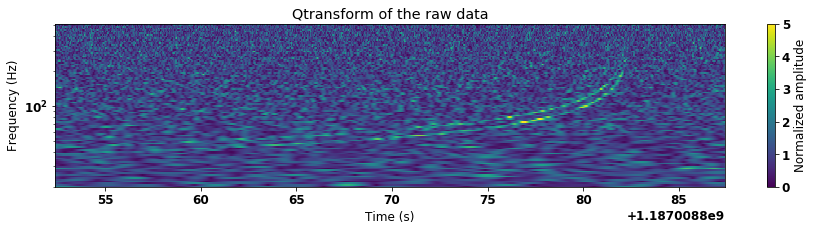

In [42]:
#qtransform of the data

white_sig01 = (sigF01/psd01**0.5).to_timeseries()
zoom = white_sig01.time_slice(merger.time - 35, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [43]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax01 = None
maxsnr01, m1max01, m2max01, tmax01 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF01.delta_f)
        hp.resize(len(sigF01))
        
        #do the max filtering
        snr = matched_filter(hp, sigF01, psd = psd01, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnr01:
            tmax01, hmax01, m1max01, m2max01, maxsnr01 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max01, m2max01, tmax01, maxsnr01))
print(merger.time)
print(maxAmpT01)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.4825068
1187008882.4
1187008882.3116212


In [44]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB01 = None
maxsnrB01, m1maxB01, m2maxB01, tmaxB01 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF01.delta_f)
        hp.resize(len(sigF01))
        
        #do the max filtering
        snr = matched_filter(hp, sigF01, psd = psd01, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrB01:
            tmaxB01, hmaxB01, m1maxB01, m2maxB01, maxsnrB01 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB01, m2maxB01, tmaxB01, maxsnrB01))
print(merger.time)
print(maxAmpT01)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008882.3140626 with a SNR of 34.6192934
1187008882.4
1187008882.3116212


ok

## For 0.05 s

In [49]:
#make the injection
time_shifts = np.arange(227, 233, 0.01)

modelNS005 = None
maxAmpNS005, timeNS005, time_dif005 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < - .04) and (timeDif > -.07) :
        print("in loop")
        modelNS005 = hpInjL
        maxAmpNS005, timeNS005, time_dif005 = max_amp, time_inj, timeDif


Waveform obtained
-1.177734375
-1.167724609375
-1.15771484375
-1.147216796875
-1.13720703125
-1.127197265625
-1.1171875
-1.1083984375
-1.098388671875
-1.08837890625
-1.078369140625
-1.068359375
-1.058349609375
-1.04833984375
-1.038330078125
-1.0283203125
-1.018310546875
-1.00830078125
-0.997802734375
-0.98779296875
-0.977783203125
-0.9677734375
-0.957763671875
-0.94775390625
-0.937744140625
-0.927734375
-0.917724609375
-0.90771484375
-0.897216796875
-0.88720703125
-0.877197265625
-0.8671875
-0.8583984375
-0.848388671875
-0.83837890625
-0.828369140625
-0.818359375
-0.808349609375
-0.79833984375
-0.788330078125
-0.7783203125
-0.768310546875
-0.75830078125
-0.747802734375
-0.73779296875
-0.727783203125
-0.7177734375
-0.707763671875
-0.69775390625
-0.687744140625
-0.677734375
-0.667724609375
-0.65771484375
-0.647216796875
-0.63720703125
-0.627197265625
-0.6171875
-0.6083984375
-0.598388671875
-0.58837890625
-0.578369140625
-0.568359375
-0.558349609375
-0.54833984375
-0.538330078125
-0.5283

4.55224609375
4.562255859375
4.572265625
4.582275390625
4.59228515625
4.602783203125
4.61279296875
4.622802734375
4.6328125
4.6416015625
4.651611328125
4.66162109375
4.671630859375
4.681640625
4.691650390625
4.70166015625
4.711669921875
4.7216796875
4.731689453125
4.74169921875
4.752197265625
4.76220703125
4.772216796875
4.7822265625
4.792236328125
4.80224609375
4.812255859375


In [50]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS005)
print("The time of this maximum is: ", timeNS005)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif005)


('The maximum amplitude of the injection is: ', 3.2780074319665815e-22)
('The time of this maximum is: ', 1187008882.3516603)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.04833984375)


In [52]:
#puting to zero all that is after the ring down
ind = modelNS005.numpy().argmax()
maxAmpT005 = modelNS005.sample_times[ind]
modelZ005 = modelNS005


for i in range(ind + 4096, len(modelZ005), 1):
    modelZ005[i] = 0


sig005 = strainL1 + modelZ005
sigF005 = sig005.to_frequencyseries()

(1e-47, 1e-42)

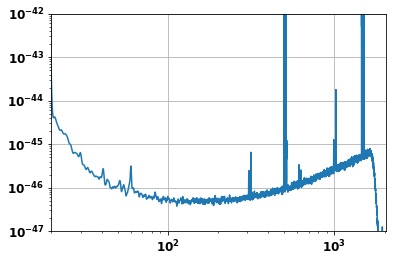

In [53]:
#psd of the added signal

p005 = sig005.psd(2)
p005 = interpolate(p005, sig005.delta_f)
psd005 = inverse_spectrum_truncation(p005, 2*sig005.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psd005.sample_frequencies, psd005)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008887.4)

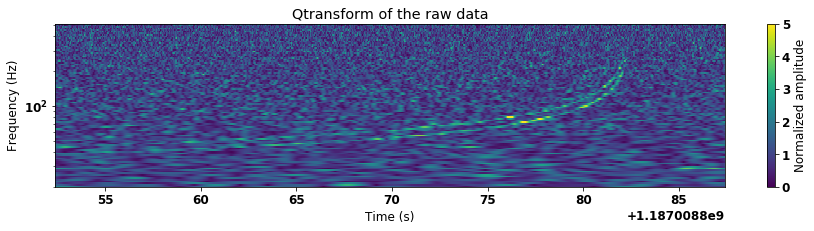

In [54]:
#qtransform of the data

white_sig005 = (sigF005/psd005**0.5).to_timeseries()
zoom = white_sig005.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [55]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax005 = None
maxsnr005, m1max005, m2max005, tmax005 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF005.delta_f)
        hp.resize(len(sigF005))
        
        #do the max filtering
        snr = matched_filter(hp, sigF005, psd = psd005, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnr005:
            tmax005, hmax005, m1max005, m2max005, maxsnr005 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max005, m2max005, tmax005, maxsnr005))
print(merger.time)
print(maxAmpT005)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.7105711
1187008882.4
1187008882.3516603


In [56]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB005 = None
maxsnrB005, m1maxB005, m2maxB005, tmaxB005 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF005.delta_f)
        hp.resize(len(sigF005))
        
        #do the max filtering
        snr = matched_filter(hp, sigF005, psd = psd005, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrB005:
            tmaxB005, hmaxB005, m1maxB005, m2maxB005, maxsnrB005 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB005, m2maxB005, tmaxB005, maxsnrB005))
print(merger.time)
print(maxAmpT005)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.090 and m2 = 1.110 at the time 1187008882.3541017 with a SNR of 33.6024306
1187008882.4
1187008882.3516603


## For 0.01s

In [59]:
#make the injection
time_shifts = np.arange(227, 233, 0.01)

modelNS001 = None
maxAmpNS001, timeNS001, time_dif001 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < -0.005) and (timeDif > -0.02) :
        print("in loop")
        modelNS001 = hpInjL
        maxAmpNS001, timeNS001, time_dif001 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [60]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS001)
print("The time of this maximum is: ", timeNS001)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif001)

('The maximum amplitude of the injection is: ', 2.870842750358993e-22)
('The time of this maximum is: ', 1187008882.3916993)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.00830078125)


In [61]:
#puting to zero all that is after the ring down
ind = modelNS001.numpy().argmax()
maxAmpT001 = modelNS001.sample_times[ind]
modelZ001 = modelNS001


for i in range(ind + 4096, len(modelZ001), 1):
    modelZ001[i] = 0


sig001 = strainL1 + modelZ001
sigF001 = sig001.to_frequencyseries()

(1e-47, 1e-42)

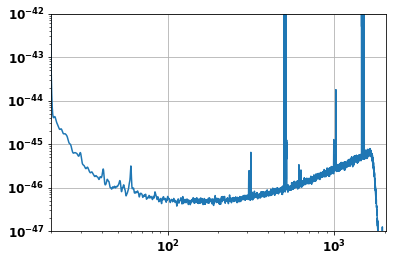

In [62]:
#psd of the added signal

p001 = sig001.psd(2)
p001 = interpolate(p001, sig001.delta_f)
psd001 = inverse_spectrum_truncation(p001, 2*sig001.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psd001.sample_frequencies, psd001)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)


(1187008852.4, 1187008887.4)

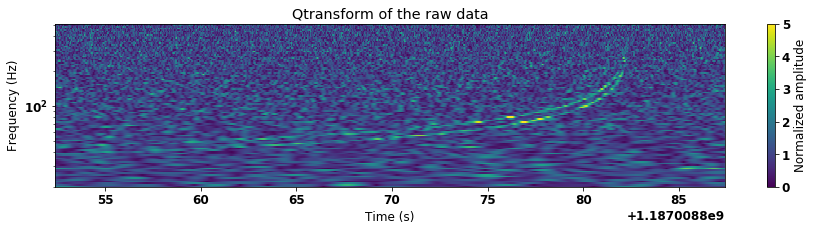

In [63]:
#qtransform of the data

white_sig001 = (sigF001/psd001**0.5).to_timeseries()
zoom = white_sig001.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [64]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax001 = None
maxsnr001, m1max001, m2max001, tmax001 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF001.delta_f)
        hp.resize(len(sigF001))
        
        #do the max filtering
        snr = matched_filter(hp, sigF001, psd = psd001, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnr001:
            tmax001, hmax001, m1max001, m2max001, maxsnr001 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max001, m2max001, tmax001, maxsnr001))
print(merger.time)
print(maxAmpT001)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.9514785
1187008882.4
1187008882.3916993


In [65]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB001 = None
maxsnrB001, m1maxB001, m2maxB001, tmaxB001 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF001.delta_f)
        hp.resize(len(sigF001))
        
        #do the max filtering
        snr = matched_filter(hp, sigF001, psd = psd001, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrB001:
            tmaxB001, hmaxB001, m1maxB001, m2maxB001, maxsnrB001 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB001, m2maxB001, tmaxB001, maxsnrB001))
print(merger.time)
print(maxAmpT001)


Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.090 and m2 = 1.110 at the time 1187008882.3946290 with a SNR of 32.2242664
1187008882.4
1187008882.3916993


## For 0s

In [66]:
#make the injection
time_shifts = np.arange(227, 233, 0.01)

modelNS0 = None
maxAmpNS0, timeNS0, time_dif0 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif <  0.005) and (timeDif > -0.01) :
        print("in loop")
        modelNS0= hpInjL
        maxAmpNS0, timeNS0, time_dif0 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [67]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNS0)
print("The time of this maximum is: ", timeNS0)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif0)


('The maximum amplitude of the injection is: ', 2.8923096536128704e-22)
('The time of this maximum is: ', 1187008882.4021974)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 0.002197265625)


In [68]:
#puting to zero all that is after the ring down
ind = modelNS0.numpy().argmax()
maxAmpT0 = modelNS0.sample_times[ind]
modelZ0 = modelNS0


for i in range(ind + 4096, len(modelZ0), 1):
    modelZ0[i] = 0


sig0 = strainL1 + modelZ0
sigF0 = sig0.to_frequencyseries()

(1e-47, 1e-42)

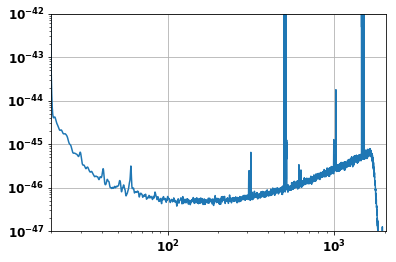

In [69]:
#psd of the added signal

p0 = sig0.psd(2)
p0 = interpolate(p0, sig0.delta_f)
psd0 = inverse_spectrum_truncation(p0, 2*sig0.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psd0.sample_frequencies, psd0)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008887.4)

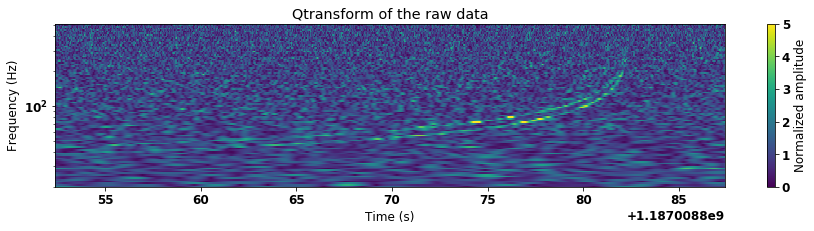

In [70]:
#qtransform of the data

white_sig0 = (sigF0/psd0**0.5).to_timeseries()
zoom = white_sig0.time_slice(merger.time - 35, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [71]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax0 = None
maxsnr0, m1max0, m2max0, tmax0 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF0.delta_f)
        hp.resize(len(sigF0))
        
        #do the max filtering
        snr = matched_filter(hp, sigF0, psd = psd0, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnr0:
            tmax0, hmax0, m1max0, m2max0, maxsnr0 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max0, m2max0, tmax0, maxsnr0))
print(merger.time)
print(maxAmpT0)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.2030537
1187008882.4
1187008882.4021974


In [73]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxB0 = None
maxsnrB0, m1maxB0, m2maxB0, tmaxB0 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF0.delta_f)
        hp.resize(len(sigF0))
        
        #do the max filtering
        snr = matched_filter(hp, sigF0, psd = psd0, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrB0:
            tmaxB0, hmaxB0, m1maxB0, m2maxB0, maxsnrB0 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxB0, m2maxB0, tmaxB0, maxsnrB0))
print(merger.time)
print(maxAmpT0)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.090 and m2 = 1.110 at the time 1187008882.4046388 with a SNR of 32.6084661
1187008882.4
1187008882.4021974


## For +0.01 s

In [74]:
#make the injection
time_shifts = np.arange(227, 233, 0.01)

modelNSP001 = None
maxAmpNSP001, timeNSP001, time_difP001 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < 0.02) and (timeDif > 0.005) :
        print("in loop")
        modelNSP001 = hpInjL
        maxAmpNSP001, timeNSP001, time_difP001 = max_amp, time_inj, timeDif

Waveform obtained
in loop


In [75]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNSP001)
print("The time of this maximum is: ", timeNSP001)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP001)

('The maximum amplitude of the injection is: ', 3.0206226885884415e-22)
('The time of this maximum is: ', 1187008882.4122071)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 0.01220703125)


In [76]:
#puting to zero all that is after the ring down
ind = modelNSP001.numpy().argmax()
maxAmpTP001 = modelNSP001.sample_times[ind]
modelZP001 = modelNSP001


for i in range(ind + 4096, len(modelZP001), 1):
    modelZP001[i] = 0


sigP001 = strainL1 + modelZP001
sigFP001 = sigP001.to_frequencyseries()


(1e-47, 1e-42)

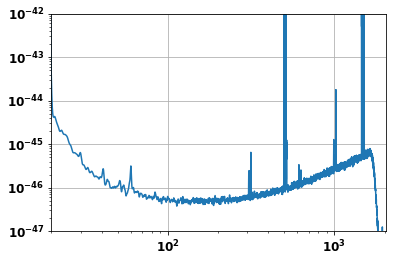

In [77]:
#psd of the added signal

pP001 = sigP001.psd(2)
pP001 = interpolate(pP001, sigP001.delta_f)
psdP001 = inverse_spectrum_truncation(pP001, 2*sigP001.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psdP001.sample_frequencies, psdP001)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008887.4)

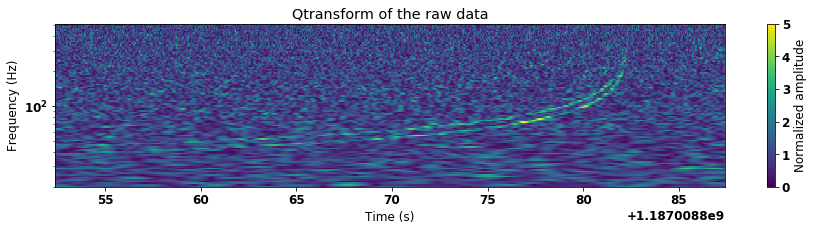

In [78]:
#qtransform of the data

white_sigP001 = (sigFP001/psdP001**0.5).to_timeseries()
zoom = white_sigP001.time_slice(merger.time - 35, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [79]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxP001 = None
maxsnrP001, m1maxP001, m2maxP001, tmaxP001 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP001.delta_f)
        hp.resize(len(sigFP001))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP001, psd = psdP001, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrP001:
            tmaxP001, hmaxP001, m1maxP001, m2maxP001, maxsnrP001 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxP001, m2maxP001, tmaxP001, maxsnrP001))
print(merger.time)
print(maxAmpTP001)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4449220 with a SNR of 24.1062187
1187008882.4
1187008882.4122071


In [80]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxBP001 = None
maxsnrBP001, m1maxBP001, m2maxBP001, tmaxBP001 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP001.delta_f)
        hp.resize(len(sigFP001))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP001, psd = psdP001, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        if snrp > maxsnrBP001:
            tmaxBP001, hmaxBP001, m1maxBP001, m2maxBP001, maxsnrBP001 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxBP001, m2maxBP001, tmaxBP001, maxsnrBP001))
print(merger.time)
print(maxAmpTP001)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.010 and m2 = 1.200 at the time 1187008882.4129395 with a SNR of 31.9117691
1187008882.4
1187008882.4122071


Ok

## For + 0.05s

In [81]:
#make the injection
time_shifts = np.arange(227, 233, 0.01)

modelNSP005 = None
maxAmpNSP005, timeNSP005, time_difP005 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < 0.06) and (timeDif > 0.04) :
        print("in loop")
        modelNSP005 = hpInjL
        maxAmpNSP005, timeNSP005, time_difP005 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [82]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNSP005)
print("The time of this maximum is: ", timeNSP005)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP005)


('The maximum amplitude of the injection is: ', 3.1710321480741804e-22)
('The time of this maximum is: ', 1187008882.4522462)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 0.05224609375)


In [83]:
#puting to zero all that is after the ring down
ind = modelNSP005.numpy().argmax()
maxAmpTP005 = modelNSP005.sample_times[ind]
modelZP005 = modelNSP005


for i in range(ind + 4096, len(modelZP005), 1):
    modelZP005[i] = 0


sigP005 = strainL1 + modelZP005
sigFP005 = sigP005.to_frequencyseries()

(1e-47, 1e-42)

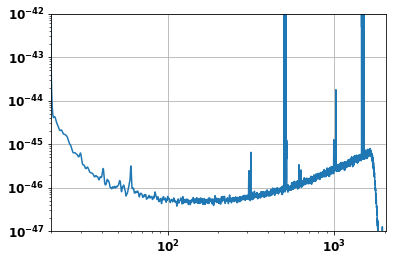

In [85]:
#psd of the added signal

pP005 = sigP005.psd(2)
pP005 = interpolate(pP005, sigP005.delta_f)
psdP005 = inverse_spectrum_truncation(pP005, 2*sigP005.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psdP005.sample_frequencies, psdP005)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008887.4)

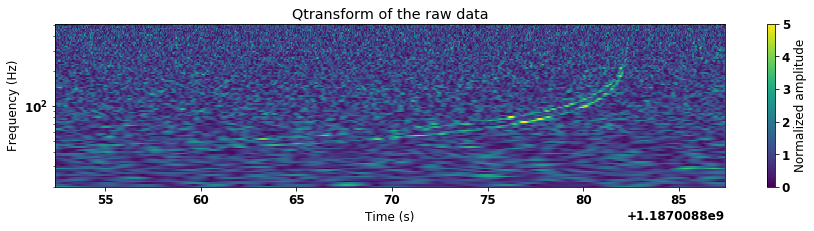

In [87]:
#qtransform of the data

white_sigP005 = (sigFP005/psdP005**0.5).to_timeseries()
zoom = white_sigP005.time_slice(merger.time - 35, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [88]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxP005 = None
maxsnrP005, m1maxP005, m2maxP005, tmaxP005 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP005.delta_f)
        hp.resize(len(sigFP005))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP005, psd = psdP005, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        if snrp > maxsnrP005:
            tmaxP005, hmaxP005, m1maxP005, m2maxP005, maxsnrP005 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxP005, m2maxP005, tmaxP005, maxsnrP005))
print(merger.time)
print(maxAmpTP005)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4451661 with a SNR of 26.0031782
1187008882.4
1187008882.4522462


In [89]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxBP005 = None
maxsnrBP005, m1maxBP005, m2maxBP005, tmaxBP005 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP005.delta_f)
        hp.resize(len(sigFP005))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP005, psd = psdP005, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrBP005:
            tmaxBP005, hmaxBP005, m1maxBP005, m2maxBP005, maxsnrBP005 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxBP005, m2maxBP005, tmaxBP005, maxsnrBP005))
print(merger.time)
print(maxAmpTP005)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008882.4529786 with a SNR of 33.5609288
1187008882.4
1187008882.4522462


It still works 

## For +0.1s

In [5]:
#make the injection
time_shifts = np.arange(227, 233, 0.1)

modelNSP01 = None
maxAmpNSP01, timeNSP01, time_difP01 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < 0.2) and (timeDif > 0.05) :
        print("in loop")
        modelNSP01 = hpInjL
        maxAmpNSP01, timeNSP01, time_difP01 = max_amp, time_inj, timeDif

Waveform obtained
in loop


In [6]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNSP01)
print("The time of this maximum is: ", timeNSP01)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP01)

('The maximum amplitude of the injection is: ', 2.8036739281017183e-22)
('The time of this maximum is: ', 1187008882.5228028)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 0.122802734375)


In [10]:
#puting to zero all that is after the ring down
ind = modelNSP01.numpy().argmax()
maxAmpTP01 = modelNSP01.sample_times[ind]
modelZP01 = modelNSP01


for i in range(ind + 4096, len(modelZP01), 1):
    modelZP01[i] = 0


sigP01 = strainL1 + modelZP01
sigFP01 = sigP01.to_frequencyseries()


(1e-47, 1e-42)

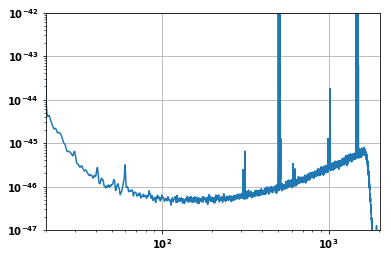

In [11]:
#psd of the added signal

pP01 = sigP01.psd(2)
pP01 = interpolate(pP01, sigP01.delta_f)
psdP01 = inverse_spectrum_truncation(pP01, 2*sigP01.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psdP01.sample_frequencies, psdP01)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008884.4)

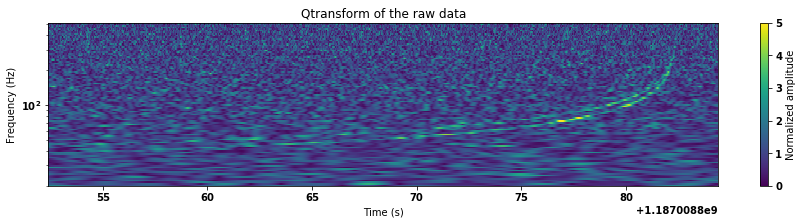

In [14]:
#qtransform of the data

white_sigP01 = (sigFP01/psdP01**0.5).to_timeseries()
zoom = white_sigP01.time_slice(merger.time - 35, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 2)

In [15]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxP01 = None
maxsnrP01, m1maxP01, m2maxP01, tmaxP01 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP01.delta_f)
        hp.resize(len(sigFP01))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP01, psd = psdP01, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrP01:
            tmaxP01, hmaxP01, m1maxP01, m2maxP01, maxsnrP01 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxP01, m2maxP01, tmaxP01, maxsnrP01))
print(merger.time)
print(maxAmpTP01)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 24.2321020
1187008882.4
1187008882.5228028


In [17]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxBP01 = None
maxsnrBP01, m1maxBP01, m2maxBP01, tmaxBP01 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP01.delta_f)
        hp.resize(len(sigFP01))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP01, psd = psdP01, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrBP01:
            tmaxBP01, hmaxBP01, m1maxBP01, m2maxBP01, maxsnrBP01 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxBP01, m2maxBP01, tmaxBP01, maxsnrBP01))
print(merger.time)
print(maxAmpTP01)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008882.5235353 with a SNR of 34.5127936
1187008882.4
1187008882.5228028


## For +0.5

In [18]:
#make the injection
time_shifts = np.arange(227, 233, 0.1)

modelNSP05 = None
maxAmpNSP05, timeNSP05, time_difP05 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif <  0.6) and (timeDif > 0.4) :
        print("in loop")
        modelNSP05 = hpInjL
        maxAmpNSP05, timeNSP05, time_difP05 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [19]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNSP05)
print("The time of this maximum is: ", timeNSP05)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP05)

('The maximum amplitude of the injection is: ', 3.1134576966105447e-22)
('The time of this maximum is: ', 1187008882.922217)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 0.522216796875)


In [24]:
#puting to zero all that is after the ring down
ind = modelNSP05.numpy().argmax()
maxAmpTP05 = modelNSP05.sample_times[ind]
modelZP05 = modelNSP05


for i in range(ind + 4096, len(modelZP05), 1):
    modelZP05[i] = 0


sigP05 = strainL1 + modelZP05
sigFP05 = sigP05.to_frequencyseries()

(1e-47, 1e-42)

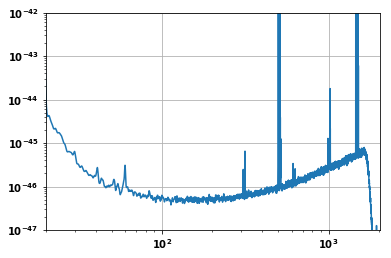

In [25]:
#psd of the added signal

pP05 = sigP05.psd(2)
pP05 = interpolate(pP05, sigP05.delta_f)
psdP05 = inverse_spectrum_truncation(pP05, 2*sigP05.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psdP05.sample_frequencies, psdP05)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008887.4)

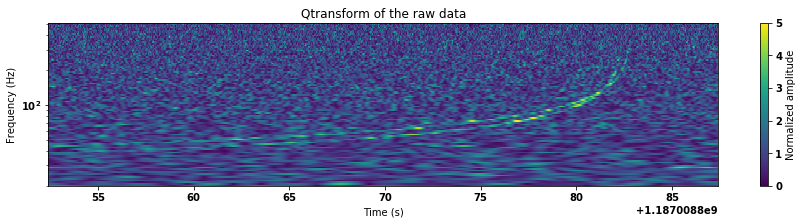

In [26]:
#qtransform of the data

white_sigP05 = (sigFP05/psdP05**0.5).to_timeseries()
zoom = white_sigP05.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [27]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxP05 = None
maxsnrP05, m1maxP05, m2maxP05, tmaxP05 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP05.delta_f)
        hp.resize(len(sigFP05))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP05, psd = psdP05, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrP05:
            tmaxP05, hmaxP05, m1maxP05, m2maxP05, maxsnrP05 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxP05, m2maxP05, tmaxP05, maxsnrP05))
print(merger.time)
print(maxAmpTP05)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.1670022
1187008882.4
1187008882.922217


In [28]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxBP05 = None
maxsnrBP05, m1maxBP05, m2maxBP05, tmaxBP05 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP05.delta_f)
        hp.resize(len(sigFP05))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP05, psd = psdP05, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        if snrp > maxsnrBP05:
            tmaxBP05, hmaxBP05, m1maxBP05, m2maxBP05, maxsnrBP05 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxBP05, m2maxBP05, tmaxBP05, maxsnrBP05))
print(merger.time)
print(maxAmpTP05)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008882.9224610 with a SNR of 33.9505244
1187008882.4
1187008882.922217


## For +1s

In [36]:
#make the injection
time_shifts = np.arange(227, 233, 0.1)

modelNSP1 = None
maxAmpNSP1, timeNSP1, time_difP1 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < 1.1) and (timeDif > 0.9) :
        print("in loop")
        modelNSP1 = hpInjL
        maxAmpNSP1, timeNSP1, time_difP1 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [37]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNSP1)
print("The time of this maximum is: ", timeNSP1)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP1)

('The maximum amplitude of the injection is: ', 3.113457696772641e-22)
('The time of this maximum is: ', 1187008883.422217)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 1.022216796875)


In [38]:
#puting to zero all that is after the ring down
ind = modelNSP1.numpy().argmax()
maxAmpTP1 = modelNSP1.sample_times[ind]
modelZP1 = modelNSP1


for i in range(ind + 4096, len(modelZP1), 1):
    modelZP1[i] = 0


sigP1 = strainL1 + modelZP1
sigFP1 = sigP1.to_frequencyseries()

(1e-47, 1e-42)

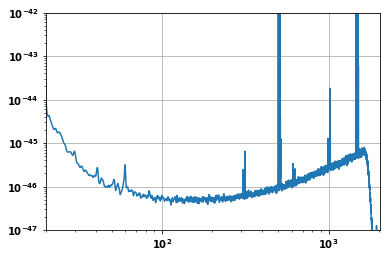

In [39]:
#psd of the added signal

pP1 = sigP1.psd(2)
pP1 = interpolate(pP1, sigP1.delta_f)
psdP1 = inverse_spectrum_truncation(pP1, 2*sigP1.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psdP1.sample_frequencies, psdP1)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008887.4)

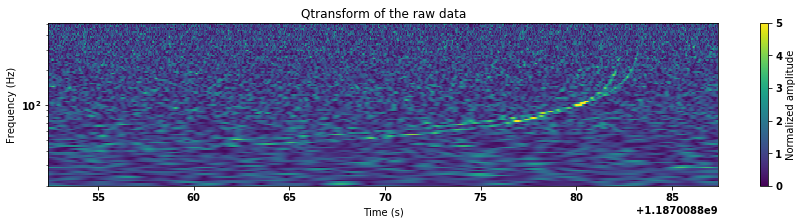

In [40]:
#qtransform of the data

white_sigP1 = (sigFP1/psdP1**0.5).to_timeseries()
zoom = white_sigP1.time_slice(merger.time - 35, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 5)

In [41]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxP1 = None
maxsnrP1, m1maxP1, m2maxP1, tmaxP1 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP1.delta_f)
        hp.resize(len(sigFP1))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP1, psd = psdP1, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrP1:
            tmaxP1, hmaxP1, m1maxP1, m2maxP1, maxsnrP1 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxP1, m2maxP1, tmaxP1, maxsnrP1))
print(merger.time)
print(maxAmpTP1)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 24.3945500
1187008882.4
1187008883.422217


In [42]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxBP1 = None
maxsnrBP1, m1maxBP1, m2maxBP1, tmaxBP1 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP1.delta_f)
        hp.resize(len(sigFP1))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP1, psd = psdP1, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrBP1:
            tmaxBP1, hmaxBP1, m1maxBP1, m2maxBP1, maxsnrBP1 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxBP1, m2maxBP1, tmaxBP1, maxsnrBP1))
print(merger.time)
print(maxAmpTP1)


Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008883.4229493 with a SNR of 33.8320420
1187008882.4
1187008883.422217


ok

## For +5 s

In [43]:
#make the injection
time_shifts = np.arange(227, 235, 0.11)

modelNSP5 = None
maxAmpNSP5, timeNSP5, time_difP5 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < 5.1) and (timeDif > 4.9) :
        print("in loop")
        modelNSP5 = hpInjL
        maxAmpNSP5, timeNSP5, time_difP5 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [44]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNSP5)
print("The time of this maximum is: ", timeNSP5)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP5)

('The maximum amplitude of the injection is: ', 2.738596844166403e-22)
('The time of this maximum is: ', 1187008887.4922853)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 5.09228515625)


In [45]:
#puting to zero all that is after the ring down
ind = modelNSP5.numpy().argmax()
maxAmpTP5 = modelNSP5.sample_times[ind]
modelZP5 = modelNSP5


for i in range(ind + 4096, len(modelZP5), 1):
    modelZP5[i] = 0


sigP5 = strainL1 + modelZP5
sigFP5 = sigP5.to_frequencyseries()

(1e-47, 1e-42)

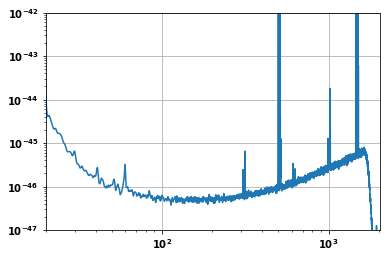

In [46]:
#psd of the added signal

pP5 = sigP5.psd(2)
pP5 = interpolate(pP5, sigP5.delta_f)
psdP5 = inverse_spectrum_truncation(pP5, 2*sigP5.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psdP5.sample_frequencies, psdP5)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008892.4)

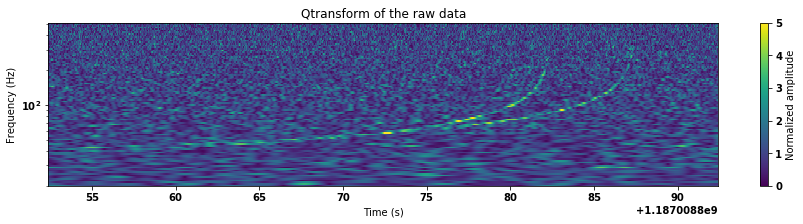

In [47]:
#qtransform of the data

white_sigP5 = (sigFP5/psdP5**0.5).to_timeseries()
zoom = white_sigP5.time_slice(merger.time - 35, merger.time + 15)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 10)

In [49]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxP5 = None
maxsnrP5, m1maxP5, m2maxP5, tmaxP5 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP5.delta_f)
        hp.resize(len(sigFP5))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP5, psd = psdP5, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrP5:
            tmaxP5, hmaxP5, m1maxP5, m2max,P5 maxsnrP5 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxP5, m2maxP5, tmaxP5, maxsnrP5))
print(merger.time)
print(maxAmpTP5)

SyntaxError: invalid syntax (<ipython-input-49-8225b08669a1>, line 32)

In [50]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxBP5 = None
maxsnrBP5, m1maxBP5, m2maxBP5, tmaxBP5 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP5.delta_f)
        hp.resize(len(sigFP5))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP5, psd = psdP5, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        if snrp > maxsnrBP5:
            tmaxBP5, hmaxBP5, m1maxBP5, m2maxBP5, maxsnrBP5 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxBP5, m2maxBP5, tmaxBP5, maxsnrBP5))
print(merger.time)
print(maxAmpTP5)


Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008887.4935060 with a SNR of 35.7342802
1187008882.4
1187008887.4922853


## +10s

In [51]:
#make the injection
time_shifts = np.arange(235, 332, 0.1)

modelNSP10 = None
maxAmpNSP10, timeNSP10, time_difP10 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < 10.1) and (timeDif > 9.9) :
        print("in loop")
        modelNSP10 = hpInjL
        maxAmpNSP10, timeNSP10, time_difP10 = max_amp, time_inj, timeDif

Waveform obtained
in loop
in loop


In [52]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNSP10)
print("The time of this maximum is: ", timeNSP10)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP10)

('The maximum amplitude of the injection is: ', 3.113457697069787e-22)
('The time of this maximum is: ', 1187008892.422217)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 10.022216796875)


In [53]:
#puting to zero all that is after the ring down
ind = modelNSP10.numpy().argmax()
maxAmpTP10 = modelNSP10.sample_times[ind]
modelZP10 = modelNSP10


for i in range(ind + 4096, len(modelZP10), 1):
    modelZP10[i] = 0


sigP10 = strainL1 + modelZP10
sigFP10 = sigP10.to_frequencyseries()

(1e-47, 1e-42)

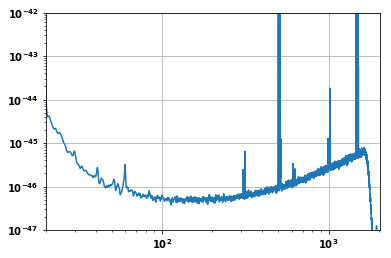

In [54]:
#psd of the added signal

pP10 = sigP10.psd(2)
pP10 = interpolate(pP10, sigP10.delta_f)
psdP10 = inverse_spectrum_truncation(pP10, 2*sigP10.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psdP10.sample_frequencies, psdP10)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008897.4)

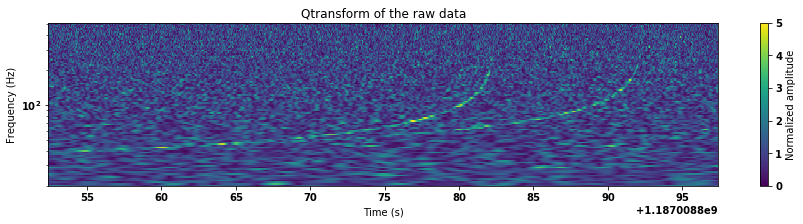

In [55]:
#qtransform of the data

white_sigP10 = (sigFP10/psdP10**0.5).to_timeseries()
zoom = white_sigP10.time_slice(merger.time - 30, merger.time + 20)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 15)

In [56]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxP10 = None
maxsnrP10, m1maxP10, m2maxP10, tmaxP10 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP10.delta_f)
        hp.resize(len(sigFP10))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP10, psd = psdP10, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrP10:
            tmaxP10, hmaxP10, m1maxP10, m2maxP10, maxsnrP10 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxP10, m2maxP10, tmaxP10, maxsnrP10))
print(merger.time)
print(maxAmpTP10)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.9738150
1187008882.4
1187008892.422217


In [58]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxBP10 = None
maxsnrBP10, m1maxBP10, m2maxBP10, tmaxBP10 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP10.delta_f)
        hp.resize(len(sigFP10))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP10, psd = psdP10, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        if snrp > maxsnrBP10:
            tmaxBP10, hmaxBP10, m1maxBP10, m2maxBP10, maxsnrBP10 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxBP10, m2maxBP10, tmaxBP10, maxsnrBP10))
print(merger.time)
print(maxAmpTP10)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008892.4229493 with a SNR of 31.8524220
1187008882.4
1187008892.422217


## For +25s

In [59]:
#make the injection
time_shifts = np.arange(235, 350, 0.1)

modelNSP25 = None
maxAmpNSP25, timeNSP25, time_difP25 = 0, 0, 0
i=0

#try to make the signal out of the loop to make it only once (LONG)
hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
                              mass2 = 1.1, distance = 50, f_lower = 20.,
                              delta_t = strainL1.delta_t)
hpInj.resize(len(strainL1))

print("Waveform obtained")

for t in time_shifts:
    #print("Get Waveform")
    #hpInj, _ = get_td_waveform(approximant = "SEOBNRv4T", mass1 = 1.1,
    #                         mass2 = 1.1, f_lower = 20.,
    #                          delta_t = strainL1.delta_t)
    #hpInj.resize(len(strainL1))
    hpInjL = hpInj.cyclic_time_shift(t)
    hpInjL.start_time = strainL1.start_time

    #print("Find max for the shift")
    ind = hpInjL.numpy().argmax()
    max_amp = hpInjL[ind]
    time_inj = hpInjL.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < 25.1) and (timeDif > 24.9) :
        print("in loop")
        modelNSP25 = hpInjL
        maxAmpNSP25, timeNSP25, time_difP25 = max_amp, time_inj, timeDif


Waveform obtained
in loop
in loop


In [60]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpNSP25)
print("The time of this maximum is: ", timeNSP25)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP25)

('The maximum amplitude of the injection is: ', 3.1134577037657186e-22)
('The time of this maximum is: ', 1187008907.422217)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 25.022216796875)


In [61]:
#puting to zero all that is after the ring down
ind = modelNSP25.numpy().argmax()
maxAmpTP25 = modelNSP25.sample_times[ind]
modelZP25 = modelNSP25


for i in range(ind + 4096, len(modelZP25), 1):
    modelZP25[i] = 0


sigP25 = strainL1 + modelZP25
sigFP25 = sigP25.to_frequencyseries()

(1e-47, 1e-42)

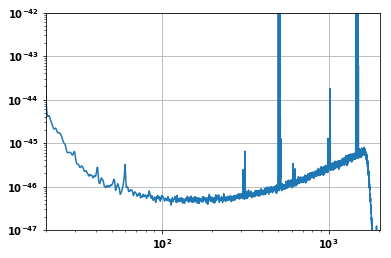

In [62]:
#psd of the added signal

pP25 = sigP25.psd(2)
pP25 = interpolate(pP25, sigP25.delta_f)
psdP25 = inverse_spectrum_truncation(pP25, 2*sigP25.sample_rate, 
                                 low_frequency_cutoff = 20.)

plt.loglog(psdP25.sample_frequencies, psdP25)
plt.grid()
plt.xlim(20,2048)
plt.ylim(1e-47, 1e-42)

(1187008852.4, 1187008909.4)

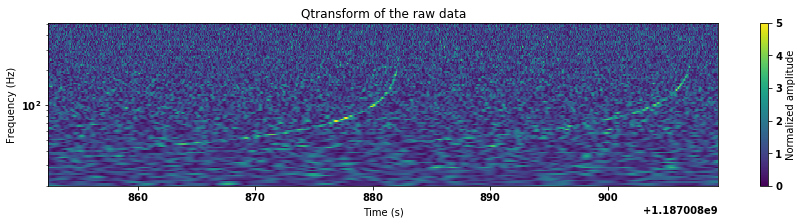

In [64]:
#qtransform of the data

white_sigP25 = (sigFP25/psdP25**0.5).to_timeseries()
zoom = white_sigP25.time_slice(merger.time - 35, merger.time + 27)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.xlim(merger.time - 30, merger.time + 27)


In [65]:
#try to find the GW170817 event before the other

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxP25 = None
maxsnrP25, m1maxP25, m2maxP25, tmaxP25 = 0, 0, 0, 0


i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP25.delta_f)
        hp.resize(len(sigFP25))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP25, psd = psdP25, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrP25:
            tmaxP25, hmaxP25, m1maxP25, m2maxP25, maxsnrP25 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxP25, m2maxP25, tmaxP25, maxsnrP25))
print(merger.time)
print(maxAmpTP25)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.7562582
1187008882.4
1187008907.422217


In [68]:
#trial to look at the other event

mass1 = np.arange(1.0, 1.25, 0.01)
mass2 = np.arange(1.0, 1.25, 0.01)

hmaxBP25 = None
maxsnrBP25, m1maxBP25, m2maxBP25, tmaxBP25 = 0, 0, 0, 0

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP25.delta_f)
        hp.resize(len(sigFP25))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP25, psd = psdP25, 
                             low_frequency_cutoff = 20.)
        snr.crop(10, 10)
        
        snr = snr.time_slice(merger.time - 120, merger.time + 27)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]
        
        if snrp > maxsnrBP25:
            tmaxBP25, hmaxBP25, m1maxBP25, m2maxBP25, maxsnrBP25 = time, hp, m1, m2, snrp
            
    i += 1
    print("Done")
    

print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxBP25, m2maxBP25, tmaxBP25, maxsnrBP25))
print(merger.time)
print(maxAmpTP25)

Mass1 : 1 / 25
Done
Mass1 : 2 / 25
Done
Mass1 : 3 / 25
Done
Mass1 : 4 / 25
Done
Mass1 : 5 / 25
Done
Mass1 : 6 / 25
Done
Mass1 : 7 / 25
Done
Mass1 : 8 / 25
Done
Mass1 : 9 / 25
Done
Mass1 : 10 / 25
Done
Mass1 : 11 / 25
Done
Mass1 : 12 / 25
Done
Mass1 : 13 / 25
Done
Mass1 : 14 / 25
Done
Mass1 : 15 / 25
Done
Mass1 : 16 / 25
Done
Mass1 : 17 / 25
Done
Mass1 : 18 / 25
Done
Mass1 : 19 / 25
Done
Mass1 : 20 / 25
Done
Mass1 : 21 / 25
Done
Mass1 : 22 / 25
Done
Mass1 : 23 / 25
Done
Mass1 : 24 / 25
Done
Mass1 : 25 / 25
Done
We found the best masses m1 = 1.100 and m2 = 1.100 at the time 1187008907.4224610 with a SNR of 31.8063732
1187008882.4
1187008907.422217
